In [3]:
# Based on https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/
import gym
import random
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [4]:
# Collect a game of Pong with random input.
frames = []
frames_ram = []
STEPS = 300

UP_ACTION = 2
DOWN_ACTION = 3

env = gym.make("Pong-ram-v0")

observation = env.reset()

for i in range(STEPS):
    gym.envs.registry
    action = random.randint(UP_ACTION, DOWN_ACTION)

    observation, reward, done, info = env.step(action)
    frames.append(env.unwrapped._get_image())
    frames_ram.append(env.unwrapped._get_ram())
    
    if done:
        observation = env.reset()
        frames.append(observation)

[192   0   0   0 110  38   0   7 129   2   0   0 192   0   0  63 255   4
   1   3   0 142   0  24 128  32   1  86 247  86 247  86 247 134 243 245
 243 240 240 242 242  32  32  64  64  64 188  65 189 116 142 152  37  37
 142   0   0   0   1 109 152  37  37 192 192 192 192 192 192 202 247 202
 247 202 247 202 247   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 180  85  54 236 242
 121 240]
Player position y: 152
Ball position x: 116
Ball position y: 142


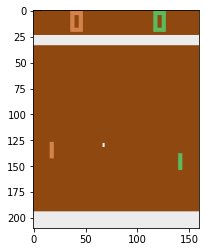

KeyboardInterrupt: 

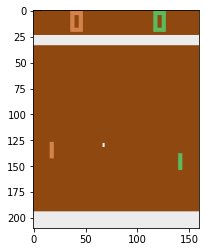

In [24]:
# Draw our frames to see what happened and print ram to find important addresses.
ram_address_position_player_y = 60
ram_address_position_ball_x = 49
ram_address_position_ball_y = 50

for i in range(len(frames)):
    plt.imshow(frames[i])
    print(frames_ram[i])
    print('Player position y: ' + str(frames_ram[i][ram_address_position_player_y]))
    print('Ball position x: ' + str(frames_ram[i][ram_address_position_ball_x]))
    print('Ball position y: ' + str(frames_ram[i][ram_address_position_ball_y]))
    display.display(pl.gcf())
    time.sleep(0.5)
    display.clear_output(wait=True)
    


In [42]:
# Create the neural network.
# TODO: What is a adam optimizer?
model = Sequential()
model.add(Dense(units=200,input_dim=3, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
import numpy as np
import gym

# gym initialization
env = gym.make("Pong-ram-v0")
observation = env.reset()
prev_input = None

# Macros
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [84]:
def discount_rewards(r, gamma):
    """ take 1D float array of rewards and compute discounted reward """
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    # we go from last reward to first one so we don't have to do exponentiations
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
        running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
        discounted_r[t] = running_add
    discounted_r -= np.mean(discounted_r) #normalizing the result
    discounted_r /= np.std(discounted_r) #idem
    return discounted_r

In [85]:
# main loop
while (True):
    ram = env.unwrapped._get_ram()
    position_player_y = ram[ram_address_position_player_y]
    position_ball_x = ram[ram_address_position_ball_x]
    position_ball_y = ram[ram_address_position_ball_y]

    # We will use as input an array of the difference between the current and previous positions.
    cur_input = np.array([position_player_y, position_ball_x, position_ball_y])
    print('Current input: ' + str(cur_input))
    print('Prev input: ' + str(prev_input))
    x = cur_input - prev_input if prev_input is not None else np.zeros(len(cur_input))
    print('Difference: ' + str(x))
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.array([x]))
    print('Prediction: ' + str(proba))
    # Variable proba is the probability prediction of how good UP_ACTION is for this frame.
    # Then select UP_ACTION by proba percent. Easy way to still allow the other action.
    # TODO: Mathematical reason for random number?
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == UP_ACTION else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment
    observation, reward, done, info = env.step(action)
    #print('Observation: ' + str(observation))
    print('Reward: ' + str(reward))
    print('Done: ' + str(done))
    print('Info: ' + str(info))
    rewards.append(reward)
    reward_sum += reward
    
    # end of an episode
    if done:
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        
        # increment episode number
        episode_nb += 1
        
        # training
        # TODO: Is np.vstack is really necessary?
        # TODO: Clarify sample_weight=discount_rewards(rewards, gamma)
        model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
                                                     
        if episode_nb % epochs_before_saving == 0:    
            model.save_weights('my_model_weights' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5')
            
        # Reinitialization
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()
        reward_sum = 0
        prev_input = None

Current input: [109   0  22]
Prev input: None
Difference: [0. 0. 0.]
Prediction: [[0.5]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [99  0 18]
Prev input: [109   0  22]
Difference: [246   0 252]
Prediction: [[3.375766e-05]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [107   0  10]
Prev input: [99  0 18]
Difference: [  8   0 248]
Prediction: [[0.00068712]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [127   0   4]
Prev input: [107   0  10]
Difference: [ 20   0 250]
Prediction: [[0.000502]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [150   0   0]
Prev input: [127   0   4]
Difference: [ 23   0 252]
Prediction: [[0.00043578]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [161   0   0]
Prev input: [150   0   0]
Difference: [11  0  0]
Prediction: [[0.46700555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [172   0   0]
Prev input: [161   0   0]
Difference: [11  0  0]
Prediction: [[0.4670

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 182]
Prev input: [203 205 190]
Difference: [  0   0 248]
Prediction: [[0.00082812]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 180]
Prev input: [203 205 182]
Difference: [  0   0 254]
Prediction: [[0.00069758]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 174]
Prev input: [203 205 180]
Difference: [  0   0 250]
Prediction: [[0.00078209]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 170]
Prev input: [203 205 174]
Difference: [  0   0 252]
Prediction: [[0.00073863]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 166]
Prev input: [203 205 170]
Difference: [  0   0 252]
Prediction: [[0.00073863]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205 160]
Prev input: [203 205 166]
Difference: [  0   0 250]
Prediction: [[0.00078209]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205

Difference: [253 254 254]
Prediction: [[0.2640595]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 44  69 100]
Prev input: [ 56  72 102]
Difference: [244 253 254]
Prediction: [[0.328735]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [41 69 98]
Prev input: [ 44  69 100]
Difference: [253   0 254]
Prediction: [[3.2761043e-05]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [42 71 94]
Prev input: [41 69 98]
Difference: [  1   2 252]
Prediction: [[0.00080487]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [57 75 86]
Prev input: [42 71 94]
Difference: [ 15   4 248]
Prediction: [[0.00073625]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [78 79 80]
Prev input: [57 75 86]
Difference: [ 21   4 250]
Prediction: [[0.00061255]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [90 81 76]
Prev input: [78 79 80]
Difference: [ 12   2 252]
Prediction: [[0.00062988]]
Reward: 0.0
Done: False
Info: {'ale.lives': 

Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 146 110]
Prev input: [203 142 114]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 150 106]
Prev input: [203 146 110]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 154 102]
Prev input: [203 150 106]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 156 100]
Prev input: [203 154 102]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 159  96]
Prev input: [203 156 100]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 161  94]
Prev input: [203 159  96]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives':

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 175  80]
Prev input: [203 172  84]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 179  76]
Prev input: [203 175  80]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 181  74]
Prev input: [203 179  76]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 185  70]
Prev input: [203 181  74]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 188  68]
Prev input: [203 185  70]
Difference: [  0   3 254]
Prediction: [[0.00082088]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 191  64]
Prev input: [203 188  68]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 194

Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 173  82]
Prev input: [203 171  84]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 177  78]
Prev input: [203 173  82]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 181  74]
Prev input: [203 177  78]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 183  72]
Prev input: [203 181  74]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 187  68]
Prev input: [203 183  72]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 191  64]
Prev input: [203 187  68]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives':

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205  22]
Prev input: [202 205  24]
Difference: [  1   0 254]
Prediction: [[0.00068197]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205  14]
Prev input: [203 205  22]
Difference: [  0   0 248]
Prediction: [[0.00082812]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205   8]
Prev input: [203 205  14]
Difference: [  0   0 250]
Prediction: [[0.00078209]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205   4]
Prev input: [203 205   8]
Difference: [  0   0 252]
Prediction: [[0.00073863]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205   0]
Prev input: [203 205   4]
Difference: [  0   0 252]
Prediction: [[0.00073863]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205   0]
Prev input: [203 205   0]
Difference: [0 0 0]
Prediction: [[0.5]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205   0]
Prev in

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 170  86]
Prev input: [203 168  88]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 172  84]
Prev input: [203 170  86]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 174  82]
Prev input: [203 172  84]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 177  78]
Prev input: [203 174  82]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 181  74]
Prev input: [203 177  78]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 184  72]
Prev input: [203 181  74]
Difference: [  0   3 254]
Prediction: [[0.00082088]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 186

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 186  70]
Prev input: [203 182  74]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 189  66]
Prev input: [203 186  70]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 192  64]
Prev input: [203 189  66]
Difference: [  0   3 254]
Prediction: [[0.00082088]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 195  60]
Prev input: [203 192  64]
Difference: [  0   3 252]
Prediction: [[0.00086918]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 199  56]
Prev input: [203 195  60]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 202  54]
Prev input: [203 199  56]
Difference: [  0   3 254]
Prediction: [[0.00082088]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 205

Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 193  62]
Prev input: [203 189  66]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 196  60]
Prev input: [203 193  62]
Difference: [  0   3 254]
Prediction: [[0.00082088]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 200  56]
Prev input: [203 196  60]
Difference: [  0   4 252]
Prediction: [[0.00091764]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [203 202  54]
Prev input: [203 200  56]
Difference: [  0   2 254]
Prediction: [[0.00077754]]
Reward: -1.0
Done: True
Info: {'ale.lives': 0}
At the end of episode 0 the total reward was : -21.0
Epoch 1/1
1090/1090 [==============================] - 0s 181us/step - loss: -1.7421 - accuracy: 0.3890
Current input: [109   0  22]
Prev input: None
Difference: [0. 0. 0.]
Prediction: [[0.5181644]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 56 192 192]
Prev input: [ 47 189 190]
Difference: [9 3 2]
Prediction: [[0.541295]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 77 195 196]
Prev input: [ 56 192 192]
Difference: [21  3  4]
Prediction: [[0.57445955]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 77 198 198]
Prev input: [ 77 195 196]
Difference: [0 3 2]
Prediction: [[0.6477823]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 82 202 202]
Prev input: [ 77 198 198]
Difference: [5 4 4]
Prediction: [[0.6017931]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 81 205 206]
Prev input: [ 82 202 202]
Difference: [255   3   4]
Prediction: [[0.7382768]]
Reward: -1.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 83 205 198]
Prev input: [ 81 205 206]
Difference: [  2   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 73 205 192]
Prev input: [ 83 205 198]
D

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 138]
Prev input: [ 38 205 146]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 136]
Prev input: [ 38 205 138]
Difference: [  0   0 254]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 132]
Prev input: [ 38 205 136]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 128]
Prev input: [ 38 205 132]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 124]
Prev input: [ 38 205 128]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 118]
Prev input: [ 38 205 124]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 114]
Prev input: [ 38 205 118]
Difference: [  0

Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 130 130]
Prev input: [ 38 205  96]
Difference: [  0 181  34]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 132 132]
Prev input: [ 38 130 130]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 134 134]
Prev input: [ 38 132 132]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 137 138]
Prev input: [ 38 134 134]
Difference: [0 3 4]
Prediction: [[0.7247483]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 140 140]
Prev input: [ 38 137 138]
Difference: [0 3 2]
Prediction: [[0.6477823]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 144 144]
Prev input: [ 38 140 140]
Difference: [0 4 4]
Prediction: [[0.73407555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 39 148 148]
Prev input: [ 38 

Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 151 152]
Prev input: [ 38 149 150]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 153 154]
Prev input: [ 38 151 152]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 51 157 158]
Prev input: [ 38 153 154]
Difference: [13  4  4]
Prediction: [[0.5707454]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 61 159 160]
Prev input: [ 51 157 158]
Difference: [10  2  2]
Prediction: [[0.5422593]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 60 161 162]
Prev input: [ 61 159 160]
Difference: [255   2   2]
Prediction: [[0.7198247]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 54 164 164]
Prev input: [ 60 161 162]
Difference: [250   3   2]
Prediction: [[0.7115267]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 42 1

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 142]
Prev input: [ 38 205 146]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 134]
Prev input: [ 38 205 142]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 128]
Prev input: [ 38 205 134]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 122]
Prev input: [ 38 205 128]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 116]
Prev input: [ 38 205 122]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 108]
Prev input: [ 38 205 116]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 104]
Prev input: [ 38 205 108]
Difference: [  0

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 156 156]
Prev input: [ 39 153 154]
Difference: [255   3   2]
Prediction: [[0.7148371]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 158 158]
Prev input: [ 38 156 156]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 160 160]
Prev input: [ 38 158 158]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 40 164 164]
Prev input: [ 38 160 160]
Difference: [2 4 4]
Prediction: [[0.6820375]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 47 166 166]
Prev input: [ 40 164 164]
Difference: [7 2 2]
Prediction: [[0.5428663]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 46 169 170]
Prev input: [ 47 166 166]
Difference: [255   3   4]
Prediction: [[0.7382768]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 42 172 172]
Prev input: [ 46 169 170

Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 114]
Prev input: [ 38 205 122]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 108]
Prev input: [ 38 205 114]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 104]
Prev input: [ 38 205 108]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205  96]
Prev input: [ 38 205 104]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 130 130]
Prev input: [ 38 205  96]
Difference: [  0 181  34]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 134 134]
Prev input: [ 38 130 130]
Difference: [0 4 4]
Prediction: [[0.73407555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 137 138]
Prev input: [ 38 134 

Prediction: [[0.73407555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 170 170]
Prev input: [ 38 168 168]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 174 174]
Prev input: [ 38 170 170]
Difference: [0 4 4]
Prediction: [[0.73407555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 177 178]
Prev input: [ 38 174 174]
Difference: [0 3 4]
Prediction: [[0.7247483]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 179 180]
Prev input: [ 38 177 178]
Difference: [0 2 2]
Prediction: [[0.6329831]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 182 182]
Prev input: [ 38 179 180]
Difference: [0 3 2]
Prediction: [[0.6477823]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 186 186]
Prev input: [ 38 182 182]
Difference: [0 4 4]
Prediction: [[0.73407555]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 190 190]
Prev in

1015/1015 [==============================] - 0s 31us/step - loss: -0.6761 - accuracy: 0.8099
Current input: [109   0  22]
Prev input: None
Difference: [0. 0. 0.]
Prediction: [[0.5385374]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [118   0  18]
Prev input: [109   0  22]
Difference: [  9   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [110   0  10]
Prev input: [118   0  18]
Difference: [248   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [101   0   6]
Prev input: [110   0  10]
Difference: [247   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [90  0  2]
Prev input: [101   0   6]
Difference: [245   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [68  0  0]
Prev input: [90  0  2]
Difference: [234   0 254]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [47  0  0]
Prev input: [

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 206]
Prev input: [ 38 201 202]
Difference: [0 4 4]
Prediction: [[0.8151839]]
Reward: -1.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 202]
Prev input: [ 38 205 206]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 196]
Prev input: [ 38 205 202]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 190]
Prev input: [ 38 205 196]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 184]
Prev input: [ 38 205 190]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 180]
Prev input: [ 38 205 184]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 172]
Prev input: [ 38 205 180]
Difference: [ 

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 150 150]
Prev input: [ 38 147 148]
Difference: [0 3 2]
Prediction: [[0.7088043]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 154 154]
Prev input: [ 38 150 150]
Difference: [0 4 4]
Prediction: [[0.8151839]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 158 158]
Prev input: [ 38 154 154]
Difference: [0 4 4]
Prediction: [[0.8151839]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 161 162]
Prev input: [ 38 158 158]
Difference: [0 3 4]
Prediction: [[0.80848366]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 163 164]
Prev input: [ 38 161 162]
Difference: [0 2 2]
Prediction: [[0.6924369]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 166 166]
Prev input: [ 38 163 164]
Difference: [0 3 2]
Prediction: [[0.7088043]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 169 170]
Prev input: [ 38 166 166]
Differenc

Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 41 197 198]
Prev input: [ 47 193 194]
Difference: [250   4   4]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 201 202]
Prev input: [ 41 197 198]
Difference: [253   4   4]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 206]
Prev input: [ 38 201 202]
Difference: [0 4 4]
Prediction: [[0.8151839]]
Reward: -1.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 202]
Prev input: [ 38 205 206]
Difference: [  0   0 252]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 194]
Prev input: [ 38 205 202]
Difference: [  0   0 248]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 188]
Prev input: [ 38 205 194]
Difference: [  0   0 250]
Prediction: [[1.]]
Reward: 0.0
Done: False
Info: {'ale.lives': 0}
Current input: [ 38 205 182]
Prev input: [ 38 205 188]
Difference: [ 

KeyboardInterrupt: 